In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import os
import cv2

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

# model & preprocess
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers

# 載入 Callbacks
from keras.callbacks import ModelCheckpoint

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
# 讀取圖片
data_path = 'D:/Coding Project/GitHub/ML100-Days/data/Kaggle/Final exam for ML 100 marathon by Cupoy/image_data/'
array_of_img = [] # this if for store all of the image data
flower_name = []
img_size = 150 # 256

flower_daisy_dir = 'train/daisy/'
flower_dandelion_dir = 'train/dandelion/'
flower_rose_dir = 'train/rose/'
flower_sunflower_dir = 'train/sunflower/'
flower_tulip_dir = 'train/tulip/'

In [3]:
def assign_label(img, flower_type):
    return flower_type

In [4]:
# this function is for load image
def make_train_data(flower_type, DIR):
    # this loop is for read each image in this folder, DIR is the foder name with images.
    for filename  in os.listdir(data_path + DIR):        
        label = assign_label(filename , flower_type)        
        path = os.path.join(data_path, DIR, filename)       
        img = cv2.imread(path, cv2.IMREAD_COLOR) # img is used to store the image data 
        img = cv2.resize(img, (img_size, img_size))
       
        array_of_img.append(np.array(img))      
        flower_name.append(str(label))   

In [5]:
# Get size of each class
size_daisy = len(os.listdir(data_path + flower_daisy_dir))
size_dandelion = len(os.listdir(data_path + flower_dandelion_dir))
size_sunflower = len(os.listdir(data_path + flower_sunflower_dir))
size_rose = len(os.listdir(data_path + flower_rose_dir))
size_tulip = len(os.listdir(data_path + flower_tulip_dir))

# Print size of each class
print('daisy data size: {}'.format(size_daisy)) # 雛菊
print('dandelion data size: {}'.format(size_dandelion)) # 蒲公英
print('sunflower data size: {}'.format(size_sunflower)) # 向日葵
print('rose data size: {}'.format(size_rose)) # 玫瑰
print('tulip data size: {}'.format(size_tulip)) # 鬱金香

daisy data size: 500
dandelion data size: 687
sunflower data size: 488
rose data size: 515
tulip data size: 633


In [6]:
make_train_data('Daisy', flower_daisy_dir)
make_train_data('Dandelion', flower_dandelion_dir)
make_train_data('Sunflower', flower_sunflower_dir)
make_train_data('Rose', flower_rose_dir)
make_train_data('Tulip', flower_tulip_dir)

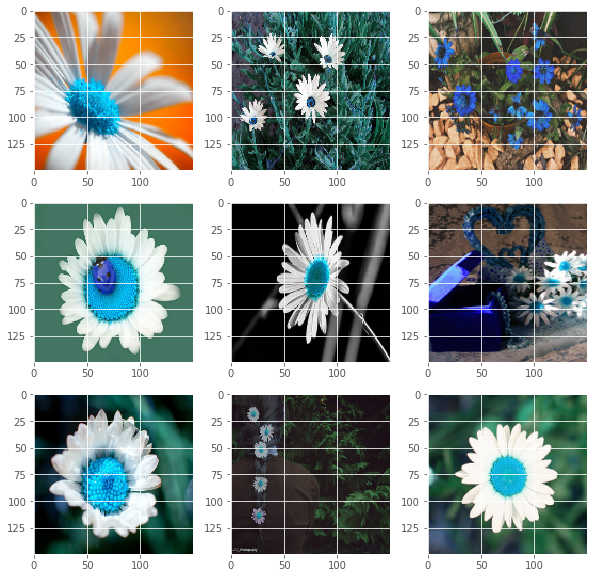

In [7]:
# Plot figure
fig = plt.figure(figsize = (10, 10))
for i in range(9):
    img = array_of_img[i]
    fig.add_subplot(3, 3, i+1)
    plt.imshow(img)
plt.show()

In [8]:
uni_flower_name = list(set(flower_name))
uni_flower_name

['Dandelion', 'Daisy', 'Rose', 'Tulip', 'Sunflower']

In [9]:
# Check size compatibility
(len(flower_name), len(array_of_img))

(2823, 2823)

In [10]:
batch_size = 1024
num_classes = 5 # Flower type 共有 5 個類別
epochs = 10 # 訓練的 epochs 數量

In [11]:
# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label_encode = le.fit_transform(flower_name)

# 對 label 進行 one-hot encoding (Y本是純數字)
Y = keras.utils.to_categorical(label_encode, num_classes)

# # Transform data to float32 and Normalize
X = np.array(array_of_img).astype('float32')/255
print('X shape:', X.shape)

X shape: (2823, 150, 150, 3)


In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15, random_state = 42)
number_of_train = x_train.shape[0]
number_of_test = x_test.shape[0]

# Flatten to one-dimention
x_train_flatten = x_train.reshape(number_of_train, x_train.shape[1] * x_train.shape[2], 3)
x_test_flatten = x_test.reshape(number_of_test, x_test.shape[1] * x_test.shape[2], 3)
print("x train flatten", x_train_flatten.shape)
print("x test flatten", x_test_flatten.shape)

x train flatten (2399, 22500, 3)
x test flatten (424, 22500, 3)


In [13]:
# 建立 CNN 神經網路模型
model = Sequential()

# 建立第一個卷積層，32 個內核，內核大小 3 x 3
model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = x_train.shape[1:]))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# 建立第二個卷積層、池化層，不需要再輸入 input_shape
model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# 新增平坦層
model.add(Flatten())

# 建立一個全連接層
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# 建立一個輸出層, 並採用softmax
model.add(Dense(num_classes, activation = 'softmax'))

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 148, 148, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        36928     
__________

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.RMSprop(),
              metrics = ['accuracy'])

# Traing Model
history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose=1,
                    validation_data = (x_test, y_test))
score = model.evaluate(x_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 2399 samples, validate on 424 samples
Epoch 1/10
